<a href="https://colab.research.google.com/github/weix20/Mobility-Data-Processing/blob/main/Modeling_for_Trip_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

big_dataset = pd.read_csv('Trips_by_Distance.csv')
small_dataset = pd.read_csv('Trips_Full Data.csv')

big_dataset['Date'] = pd.to_datetime(big_dataset['Date'])
small_dataset['Date'] = pd.to_datetime(small_dataset['Date'])

display(big_dataset.head())
display(small_dataset.head())


,Level,Date,State FIPS,State Postal Code,County FIPS,County Name,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,...,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month
0,National,2019-01-01,NaN,NaN,NaN,NaN,77433867.0,248733553.0,8.977844e+08,241667151.0,...,129670778.0,116904343.0,40432062.0,15686639.0,7525563.0,1806022.0,1728112.0,00-00000-20190101,0.0,1.0
1,National,2019-01-02,NaN,NaN,NaN,NaN,61305201.0,264862219.0,1.139452e+09,291276735.0,...,171637514.0,167412698.0,56148976.0,17739183.0,7817044.0,1962301.0,1531219.0,00-00000-20190102,0.0,1.0
2,National,2019-01-03,NaN,NaN,NaN,NaN,63050480.0,263116940.0,1.162753e+09,296375014.0,...,175775410.0,172027487.0,57632422.0,18366626.0,8124548.0,2038099.0,1567072.0,00-00000-20190103,0.0,1.0
3,National,2019-01-04,NaN,NaN,NaN,NaN,61803652.0,264363768.0,1.181954e+09,293159631.0,...,181324645.0,176144493.0,58761592.0,19315785.0,8687318.0,2096065.0,1569185.0,00-00000-20190104,0.0,1.0
4,National,2019-01-05,NaN,NaN,NaN,NaN,64389745.0,261777675.0,1.180477e+09,295459014.0,...,180941769.0,165239790.0,54842134.0,19363939.0,8490791.0,1991159.0,1438664.0,00-00000-20190105,0.0,1.0


,Month of Date,Week of Date,Year of Date,Level,Date,Week Ending Date,Trips <1 Mile,People Not Staying at Home,Population Staying at Home,Trips,...,Trips 10-25 Miles,Trips 100-250 Miles,Trips 100+ Miles,Trips 25-100 Miles,Trips 25-50 Miles,Trips 250-500 Miles,Trips 3-5 Miles,Trips 5-10 Miles,Trips 50-100 Miles,Trips 500+ Miles
0,August,Week 32,2019,National,2019-08-04,10-Aug-19,292959749,258404133,67763287,1322685497,...,200922270,8595827,15338786,79429125,59517188,2273613,171336406,216121882,19911937,4469346
1,August,Week 32,2019,National,2019-08-05,10-Aug-19,317133861,262199758,63967662,1412564488,...,228809869,6535920,12563068,86004297,68184743,1941260,178996059,231048425,17819554,4085888
2,August,Week 32,2019,National,2019-08-06,10-Aug-19,324443205,260096133,66071287,1437762102,...,235621127,5993704,11104823,87599579,70149166,1741994,179210645,233248732,17450413,3369125
3,August,Week 32,2019,National,2019-08-07,10-Aug-19,358483024,258878802,67288618,1543710309,...,249988663,5379881,8528574,92200386,74381367,1272248,189163336,243872277,17819019,1876445
4,August,Week 32,2019,National,2019-08-08,10-Aug-19,300765870,262410045,63757375,1382044815,...,226055368,6259735,12892348,84193587,66724543,1957888,179346163,230933709,17469044,4674725


In [2]:
print("Big Dataset Info:")
display(pd.DataFrame({
    'Column': big_dataset.columns,
    'Non-Null Count': [big_dataset[col].notna().sum() for col in big_dataset.columns],
    'Dtype': big_dataset.dtypes.values
}))

print("\nSmall Dataset Info:")
display(pd.DataFrame({
    'Column': small_dataset.columns,
    'Non-Null Count': [small_dataset[col].notna().sum() for col in small_dataset.columns],
    'Dtype': small_dataset.dtypes.values
}))

missing_big = big_dataset.isnull().sum()
missing_small = small_dataset.isnull().sum()

display(pd.DataFrame({
    'Big Dataset Missing': missing_big[missing_big > 0],
    'Small Dataset Missing': missing_small[missing_small > 0]
}))


Big Dataset Info:


,Column,Non-Null Count,Dtype
0,Level,121577,object
1,Date,121577,datetime64[ns]
2,State FIPS,120690,float64
3,State Postal Code,120690,object
4,County FIPS,75453,float64
5,County Name,75453,object
6,Population Staying at Home,121178,float64
7,Population Not Staying at Home,121178,float64
8,Number of Trips,121178,float64
9,Number of Trips <1,121178,float64



Small Dataset Info:


,Column,Non-Null Count,Dtype
0,Month of Date,7,object
1,Week of Date,7,object
2,Year of Date,7,int64
3,Level,7,object
4,Date,7,datetime64[ns]
5,Week Ending Date,7,object
6,Trips <1 Mile,7,int64
7,People Not Staying at Home,7,int64
8,Population Staying at Home,7,int64
9,Trips,7,int64


,Big Dataset Missing,Small Dataset Missing
County FIPS,46124,NaN
County Name,46124,NaN
Month,1,NaN
Number of Trips,399,NaN
Number of Trips 1-3,399,NaN
Number of Trips 10-25,399,NaN
Number of Trips 100-250,399,NaN
Number of Trips 25-50,399,NaN
Number of Trips 250-500,399,NaN
Number of Trips 3-5,399,NaN


In [3]:
national_data = big_dataset[big_dataset['Level'] == 'National'].copy()
national_data = national_data.drop(columns=['State FIPS', 'State Postal Code', 'County FIPS', 'County Name'])

display(national_data.head())
display(pd.DataFrame({
    'Metric': ['Total Records', 'Date Range Start', 'Date Range End'],
    'Value': [len(national_data), national_data['Date'].min(), national_data['Date'].max()]
}))


,Level,Date,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips <1,Number of Trips 1-3,Number of Trips 3-5,Number of Trips 5-10,Number of Trips 10-25,Number of Trips 25-50,Number of Trips 50-100,Number of Trips 100-250,Number of Trips 250-500,Number of Trips >=500,Row ID,Week,Month
0,National,2019-01-01,77433867.0,248733553.0,8.977844e+08,241667151.0,234284795.0,108078903.0,129670778.0,116904343.0,40432062.0,15686639.0,7525563.0,1806022.0,1728112.0,00-00000-20190101,0.0,1.0
1,National,2019-01-02,61305201.0,264862219.0,1.139452e+09,291276735.0,285887315.0,138039296.0,171637514.0,167412698.0,56148976.0,17739183.0,7817044.0,1962301.0,1531219.0,00-00000-20190102,0.0,1.0
2,National,2019-01-03,63050480.0,263116940.0,1.162753e+09,296375014.0,290074425.0,140771581.0,175775410.0,172027487.0,57632422.0,18366626.0,8124548.0,2038099.0,1567072.0,00-00000-20190103,0.0,1.0
3,National,2019-01-04,61803652.0,264363768.0,1.181954e+09,293159631.0,295643296.0,145251819.0,181324645.0,176144493.0,58761592.0,19315785.0,8687318.0,2096065.0,1569185.0,00-00000-20190104,0.0,1.0
4,National,2019-01-05,64389745.0,261777675.0,1.180477e+09,295459014.0,304168709.0,148540651.0,180941769.0,165239790.0,54842134.0,19363939.0,8490791.0,1991159.0,1438664.0,00-00000-20190105,0.0,1.0


,Metric,Value
0,Total Records,887
1,Date Range Start,2019-01-01 00:00:00
2,Date Range End,2021-06-05 00:00:00


In [4]:
home_stats = pd.DataFrame({
    'Metric': [
        'Total People Staying at Home',
        'Total People Not Staying at Home',
        'Average Daily Staying at Home',
        'Average Daily Not Staying at Home'
    ],
    'Value': [
        national_data['Population Staying at Home'].sum(),
        national_data['Population Not Staying at Home'].sum(),
        national_data['Population Staying at Home'].mean(),
        national_data['Population Not Staying at Home'].mean()
    ]
})

display(home_stats)


,Metric,Value
0,Total People Staying at Home,6.466974e+10
1,Total People Not Staying at Home,2.252603e+11
2,Average Daily Staying at Home,7.290839e+07
3,Average Daily Not Staying at Home,2.539575e+08


In [5]:
trip_columns = [
    'Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5',
    'Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50',
    'Number of Trips 50-100', 'Number of Trips 100-250', 'Number of Trips 250-500',
    'Number of Trips >=500'
]

distance_midpoints = [0.5, 2, 4, 7.5, 17.5, 37.5, 75, 175, 375, 500]

national_data['Weighted_Distance'] = sum(
    national_data[col] * dist for col, dist in zip(trip_columns, distance_midpoints)
)

national_data['Total_Trips'] = national_data[trip_columns].sum(axis=1)
national_data['Average_Distance'] = national_data['Weighted_Distance'] / national_data['Total_Trips']

distance_stats = pd.DataFrame({
    'Metric': [
        'Average Travel Distance (miles)',
        'Median Travel Distance (miles)',
        'Min Travel Distance (miles)',
        'Max Travel Distance (miles)'
    ],
    'Value': [
        national_data['Average_Distance'].mean(),
        national_data['Average_Distance'].median(),
        national_data['Average_Distance'].min(),
        national_data['Average_Distance'].max()
    ]
})

display(distance_stats)


,Metric,Value
0,Average Travel Distance (miles),10.352414
1,Median Travel Distance (miles),10.226924
2,Min Travel Distance (miles),8.438659
3,Max Travel Distance (miles),15.852380


In [6]:
dates_10_25 = national_data[national_data['Number of Trips 10-25'] > 100000000]
dates_50_100 = national_data[national_data['Number of Trips 50-100'] > 100000000]

comparison_summary = pd.DataFrame({
    'Category': ['10-25 Trips', '50-100 Trips'],
    'Number of Dates': [len(dates_10_25), len(dates_50_100)],
    'Total Trips': [
        dates_10_25['Number of Trips 10-25'].sum(),
        dates_50_100['Number of Trips 50-100'].sum()
    ],
    'Average Trips per Date': [
        dates_10_25['Number of Trips 10-25'].mean(),
        dates_50_100['Number of Trips 50-100'].mean()
    ]
})

display(comparison_summary)

print("\nFirst 10 Dates with >100M people conducting 10-25 trips:")
display(dates_10_25[['Date', 'Number of Trips 10-25']].head(10))

print("\nFirst 10 Dates with >100M people conducting 50-100 trips:")
display(dates_50_100[['Date', 'Number of Trips 50-100']].head(10))


,Category,Number of Dates,Total Trips,Average Trips per Date
0,10-25 Trips,881,1.581169e+11,1.794743e+08
1,50-100 Trips,0,0.000000e+00,NaN



First 10 Dates with >100M people conducting 10-25 trips:


,Date,Number of Trips 10-25
0,2019-01-01,116904343.0
1,2019-01-02,167412698.0
2,2019-01-03,172027487.0
3,2019-01-04,176144493.0
4,2019-01-05,165239790.0
5,2019-01-06,144091310.0
6,2019-01-07,165178406.0
7,2019-01-08,166322929.0
8,2019-01-09,166169173.0
9,2019-01-10,171169293.0



First 10 Dates with >100M people conducting 50-100 trips:


,Date,Number of Trips 50-100


In [7]:
def process_sequential(data):
    return data.groupby('Date').agg({
        'Population Staying at Home': 'sum',
        'Population Not Staying at Home': 'sum',
        'Number of Trips': 'sum',
        'Number of Trips 10-25': 'sum',
        'Number of Trips 50-100': 'sum'
    })

start_time = time.time()
sequential_result = process_sequential(national_data)
sequential_time = time.time() - start_time

print(f"Sequential Processing Time: {sequential_time:.4f} seconds")
display(sequential_result.head(10))


Sequential Processing Time: 0.0194 seconds


,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips 10-25,Number of Trips 50-100
Date,,,,,
2019-01-01,77433867.0,248733553.0,8.977844e+08,116904343.0,15686639.0
2019-01-02,61305201.0,264862219.0,1.139452e+09,167412698.0,17739183.0
2019-01-03,63050480.0,263116940.0,1.162753e+09,172027487.0,18366626.0
2019-01-04,61803652.0,264363768.0,1.181954e+09,176144493.0,19315785.0
2019-01-05,64389745.0,261777675.0,1.180477e+09,165239790.0,19363939.0
2019-01-06,66498949.0,259668471.0,1.073941e+09,144091310.0,17418975.0
2019-01-07,62840591.0,263326829.0,1.144742e+09,165178406.0,17491604.0
2019-01-08,63064293.0,263103127.0,1.141498e+09,166322929.0,17369502.0
2019-01-09,62305155.0,263862265.0,1.135629e+09,166169173.0,17543261.0


In [8]:
def process_chunk(chunk):
    return chunk.groupby('Date').agg({
        'Population Staying at Home': 'sum',
        'Population Not Staying at Home': 'sum',
        'Number of Trips': 'sum',
        'Number of Trips 10-25': 'sum',
        'Number of Trips 50-100': 'sum'
    })

def parallel_process(data, n_processors):
    chunk_size = len(data) // n_processors
    chunks = [data.iloc[i:i + chunk_size] for i in range(0, len(data), chunk_size)]

    start_time = time.time()
    with Pool(n_processors) as pool:
        results = pool.map(process_chunk, chunks)

    final_result = pd.concat(results).groupby('Date').sum()
    processing_time = time.time() - start_time

    return final_result, processing_time


In [9]:
result_10, time_10 = parallel_process(national_data, 10)

print(f"Parallel Processing Time (10 processors): {time_10:.4f} seconds")
display(result_10.head(10))


Parallel Processing Time (10 processors): 0.6624 seconds


,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips 10-25,Number of Trips 50-100
Date,,,,,
2019-01-01,77433867.0,248733553.0,8.977844e+08,116904343.0,15686639.0
2019-01-02,61305201.0,264862219.0,1.139452e+09,167412698.0,17739183.0
2019-01-03,63050480.0,263116940.0,1.162753e+09,172027487.0,18366626.0
2019-01-04,61803652.0,264363768.0,1.181954e+09,176144493.0,19315785.0
2019-01-05,64389745.0,261777675.0,1.180477e+09,165239790.0,19363939.0
2019-01-06,66498949.0,259668471.0,1.073941e+09,144091310.0,17418975.0
2019-01-07,62840591.0,263326829.0,1.144742e+09,165178406.0,17491604.0
2019-01-08,63064293.0,263103127.0,1.141498e+09,166322929.0,17369502.0
2019-01-09,62305155.0,263862265.0,1.135629e+09,166169173.0,17543261.0


In [10]:
result_20, time_20 = parallel_process(national_data, 20)

print(f"Parallel Processing Time (20 processors): {time_20:.4f} seconds")
display(result_20.head(10))


Parallel Processing Time (20 processors): 1.7005 seconds


,Population Staying at Home,Population Not Staying at Home,Number of Trips,Number of Trips 10-25,Number of Trips 50-100
Date,,,,,
2019-01-01,77433867.0,248733553.0,8.977844e+08,116904343.0,15686639.0
2019-01-02,61305201.0,264862219.0,1.139452e+09,167412698.0,17739183.0
2019-01-03,63050480.0,263116940.0,1.162753e+09,172027487.0,18366626.0
2019-01-04,61803652.0,264363768.0,1.181954e+09,176144493.0,19315785.0
2019-01-05,64389745.0,261777675.0,1.180477e+09,165239790.0,19363939.0
2019-01-06,66498949.0,259668471.0,1.073941e+09,144091310.0,17418975.0
2019-01-07,62840591.0,263326829.0,1.144742e+09,165178406.0,17491604.0
2019-01-08,63064293.0,263103127.0,1.141498e+09,166322929.0,17369502.0
2019-01-09,62305155.0,263862265.0,1.135629e+09,166169173.0,17543261.0


In [11]:
speedup_10 = sequential_time / time_10
speedup_20 = sequential_time / time_20
efficiency_10 = (speedup_10 / 10) * 100
efficiency_20 = (speedup_20 / 20) * 100

performance_comparison = pd.DataFrame({
    'Method': ['Sequential', '10 Processors', '20 Processors'],
    'Time (seconds)': [sequential_time, time_10, time_20],
    'Speedup': [1.0, speedup_10, speedup_20],
    'Efficiency (%)': [100.0, efficiency_10, efficiency_20]
})

display(performance_comparison)


,Method,Time (seconds),Speedup,Efficiency (%)
0,Sequential,0.019422,1.000000,100.000000
1,10 Processors,0.662435,0.029320,0.293195
2,20 Processors,1.700474,0.011422,0.057108


In [12]:
national_data['Short_Distance'] = national_data[
    ['Number of Trips <1', 'Number of Trips 1-3', 'Number of Trips 3-5']
].sum(axis=1)

national_data['Medium_Distance'] = national_data[
    ['Number of Trips 5-10', 'Number of Trips 10-25', 'Number of Trips 25-50']
].sum(axis=1)

national_data['Long_Distance'] = national_data[
    ['Number of Trips 50-100', 'Number of Trips 100-250',
     'Number of Trips 250-500', 'Number of Trips >=500']
].sum(axis=1)

category_stats = pd.DataFrame({
    'Distance Category': ['Short (<5 miles)', 'Medium (5-50 miles)', 'Long (>50 miles)'],
    'Total Trips': [
        national_data['Short_Distance'].sum(),
        national_data['Medium_Distance'].sum(),
        national_data['Long_Distance'].sum()
    ],
    'Average per Day': [
        national_data['Short_Distance'].mean(),
        national_data['Medium_Distance'].mean(),
        national_data['Long_Distance'].mean()
    ],
    'Percentage': [
        (national_data['Short_Distance'].sum() / national_data['Total_Trips'].sum()) * 100,
        (national_data['Medium_Distance'].sum() / national_data['Total_Trips'].sum()) * 100,
        (national_data['Long_Distance'].sum() / national_data['Total_Trips'].sum()) * 100
    ]
})

display(category_stats)


,Distance Category,Total Trips,Average per Day,Percentage
0,Short (<5 miles),6.504488e+11,7.333132e+08,61.991316
1,Medium (5-50 miles),3.722869e+11,4.197147e+08,35.480977
2,Long (>50 miles),2.652217e+10,2.990098e+07,2.527707


In [13]:
start_date = small_dataset['Date'].min()
end_date = small_dataset['Date'].max()

filtered_data = national_data[
    (national_data['Date'] >= start_date) & (national_data['Date'] <= end_date)
].copy()

X = filtered_data[['Population Not Staying at Home', 'Short_Distance',
                    'Medium_Distance', 'Long_Distance']]
y = filtered_data['Total_Trips']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

display(pd.DataFrame({
    'Dataset': ['Training', 'Testing'],
    'Samples': [len(X_train), len(X_test)],
    'Percentage': [80, 20]
}))


Training set size: 5
Testing set size: 2


,Dataset,Samples,Percentage
0,Training,5,80
1,Testing,2,20


In [14]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

lr_metrics = pd.DataFrame({
    'Metric': ['R² Score', 'MSE', 'RMSE', 'MAE'],
    'Value': [
        r2_score(y_test, y_pred_lr),
        mean_squared_error(y_test, y_pred_lr),
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        mean_absolute_error(y_test, y_pred_lr)
    ]
})

print("Linear Regression Model Performance:")
display(lr_metrics)

coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', ascending=False)

display(coefficients)


Linear Regression Model Performance:


,Metric,Value
0,R² Score,1.000000e+00
1,MSE,7.105427e-13
2,RMSE,8.429370e-07
3,MAE,5.960464e-07


,Feature,Coefficient
1,Short_Distance,1.000000e+00
2,Medium_Distance,1.000000e+00
3,Long_Distance,1.000000e+00
0,Population Not Staying at Home,2.857447e-13


In [15]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rf_metrics = pd.DataFrame({
    'Metric': ['R² Score', 'MSE', 'RMSE', 'MAE'],
    'Value': [
        r2_score(y_test, y_pred_rf),
        mean_squared_error(y_test, y_pred_rf),
        np.sqrt(mean_squared_error(y_test, y_pred_rf)),
        mean_absolute_error(y_test, y_pred_rf)
    ]
})

print("Random Forest Model Performance:")
display(rf_metrics)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

display(feature_importance)


Random Forest Model Performance:


,Metric,Value
0,R² Score,-1.265167e+00
1,MSE,4.574636e+15
2,RMSE,6.763606e+07
3,MAE,4.880333e+07


,Feature,Importance
1,Short_Distance,0.504733
2,Medium_Distance,0.206968
0,Population Not Staying at Home,0.166270
3,Long_Distance,0.122028


In [16]:
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R² Score': [
        r2_score(y_test, y_pred_lr),
        r2_score(y_test, y_pred_rf)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf))
    ],
    'MAE': [
        mean_absolute_error(y_test, y_pred_lr),
        mean_absolute_error(y_test, y_pred_rf)
    ]
})

display(model_comparison)

best_model = 'Random Forest' if r2_score(y_test, y_pred_rf) > r2_score(y_test, y_pred_lr) else 'Linear Regression'
print(f"\nBest Model: {best_model}")


,Model,R² Score,RMSE,MAE
0,Linear Regression,1.000000,8.429370e-07,5.960464e-07
1,Random Forest,-1.265167,6.763606e+07,4.880333e+07



Best Model: Linear Regression


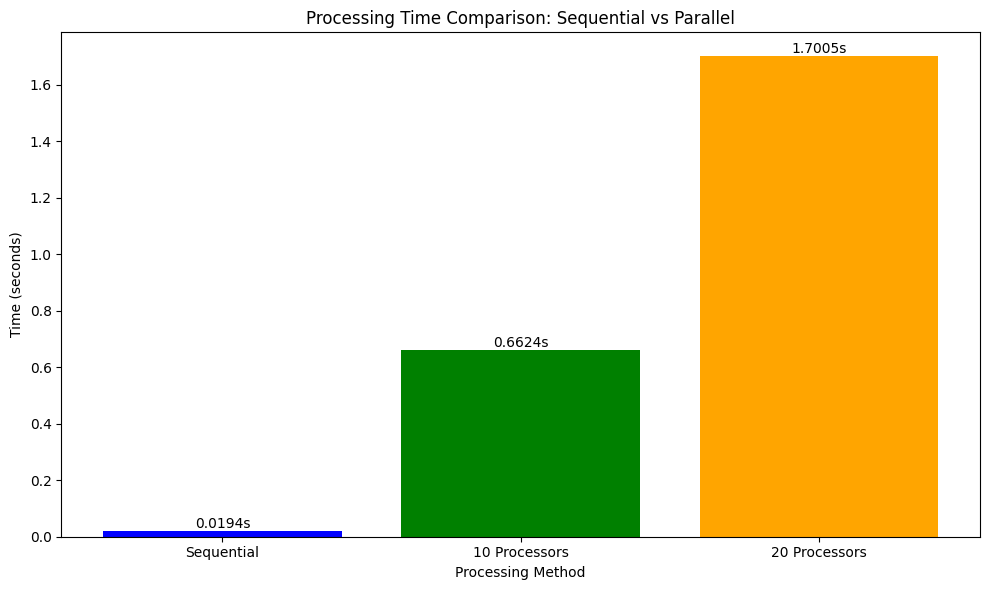

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

methods = performance_comparison['Method']
times = performance_comparison['Time (seconds)']

bars = ax.bar(methods, times, color=['blue', 'green', 'orange'])
ax.set_xlabel('Processing Method')
ax.set_ylabel('Time (seconds)')
ax.set_title('Processing Time Comparison: Sequential vs Parallel')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}s', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('processing_time_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


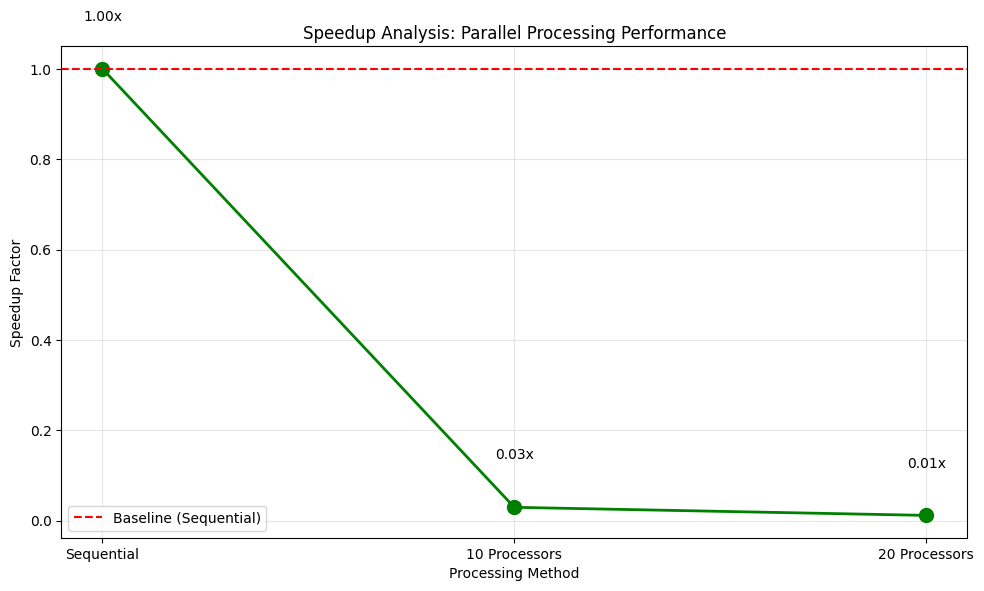

In [18]:
fig, ax = plt.subplots(figsize=(10, 6))

speedups = performance_comparison['Speedup']
ax.plot(methods, speedups, marker='o', linewidth=2, markersize=10, color='green')
ax.axhline(y=1, color='red', linestyle='--', label='Baseline (Sequential)')

ax.set_xlabel('Processing Method')
ax.set_ylabel('Speedup Factor')
ax.set_title('Speedup Analysis: Parallel Processing Performance')
ax.legend()
ax.grid(True, alpha=0.3)

for i, (method, speedup) in enumerate(zip(methods, speedups)):
    ax.text(i, speedup + 0.1, f'{speedup:.2f}x', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


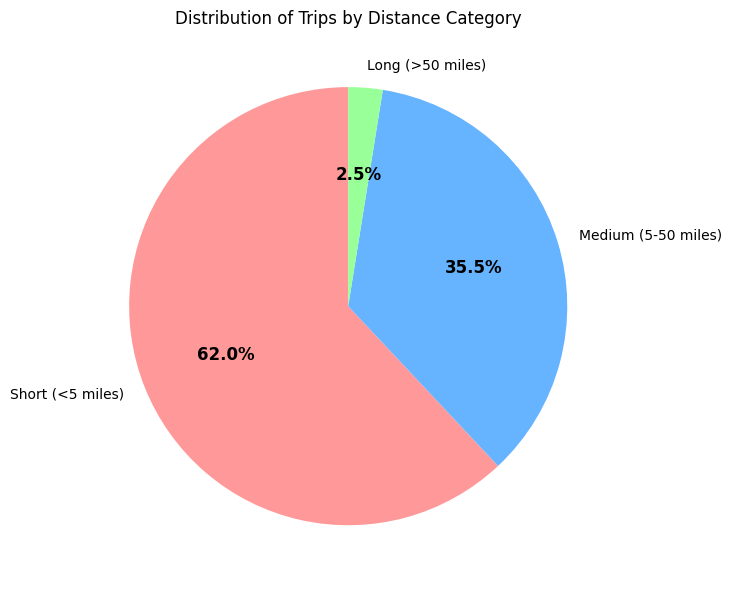

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = category_stats['Distance Category']
percentages = category_stats['Percentage']

colors = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = ax.pie(percentages, labels=categories, autopct='%1.1f%%',
                                    colors=colors, startangle=90)

ax.set_title('Distribution of Trips by Distance Category')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

plt.tight_layout()
plt.savefig('distance_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


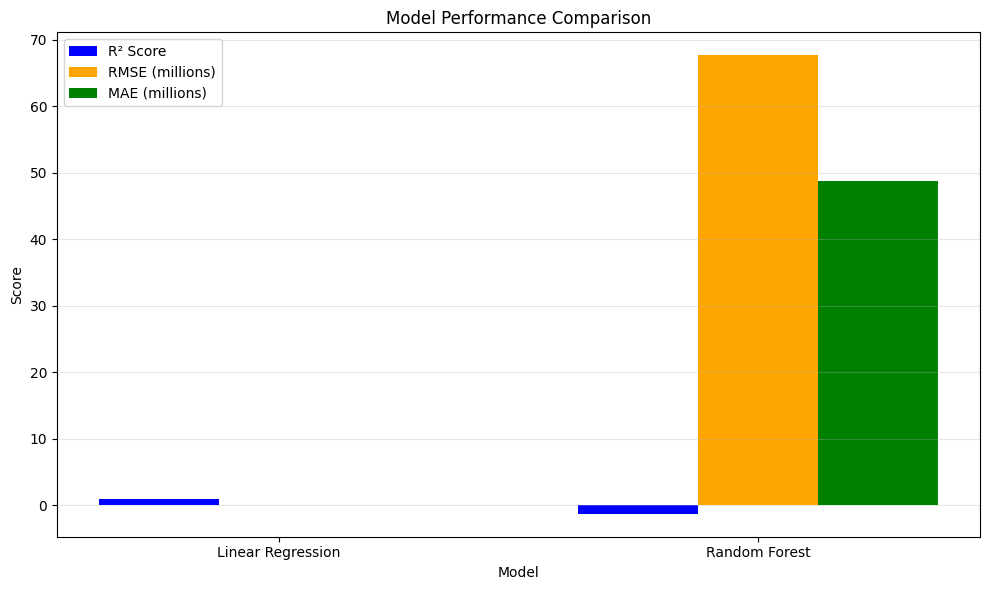

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(model_comparison['Model']))
width = 0.25

r2_bars = ax.bar(x - width, model_comparison['R² Score'], width, label='R² Score', color='blue')
rmse_bars = ax.bar(x, model_comparison['RMSE']/1e6, width, label='RMSE (millions)', color='orange')
mae_bars = ax.bar(x + width, model_comparison['MAE']/1e6, width, label='MAE (millions)', color='green')

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_comparison['Model'])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


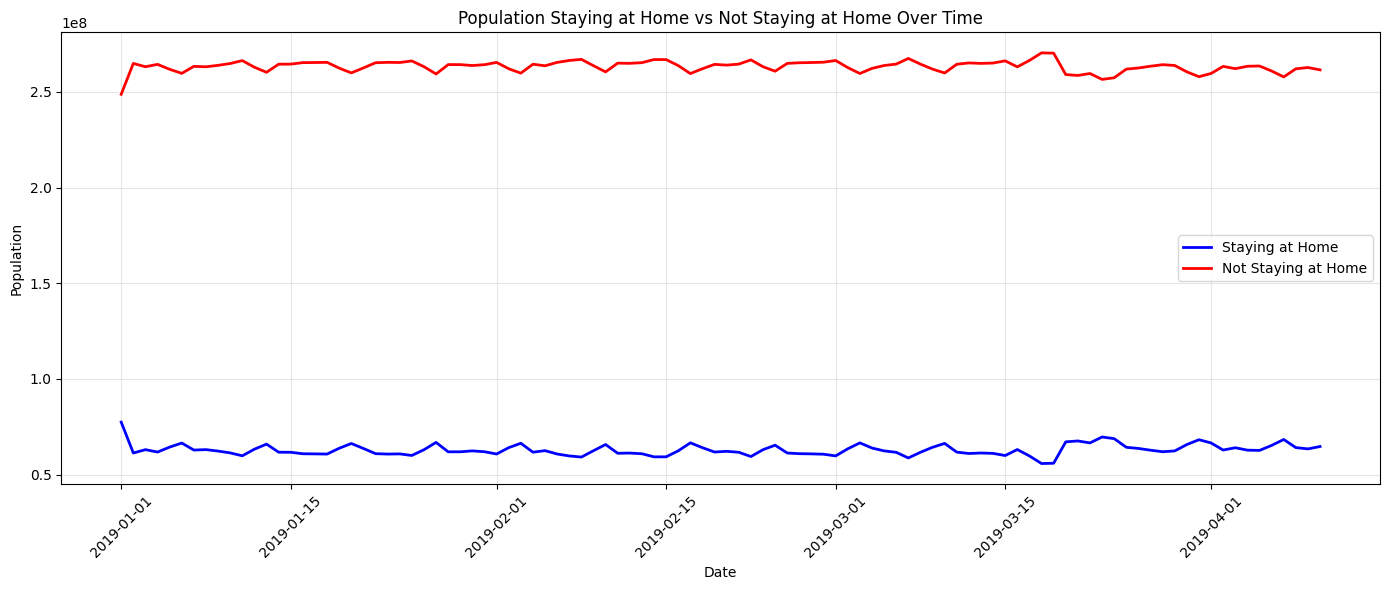

In [21]:
fig, ax = plt.subplots(figsize=(14, 6))

sample_data = national_data.head(100)

ax.plot(sample_data['Date'], sample_data['Population Staying at Home'],
        label='Staying at Home', linewidth=2, color='blue')
ax.plot(sample_data['Date'], sample_data['Population Not Staying at Home'],
        label='Not Staying at Home', linewidth=2, color='red')

ax.set_xlabel('Date')
ax.set_ylabel('Population')
ax.set_title('Population Staying at Home vs Not Staying at Home Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('population_trends.png', dpi=300, bbox_inches='tight')
plt.show()


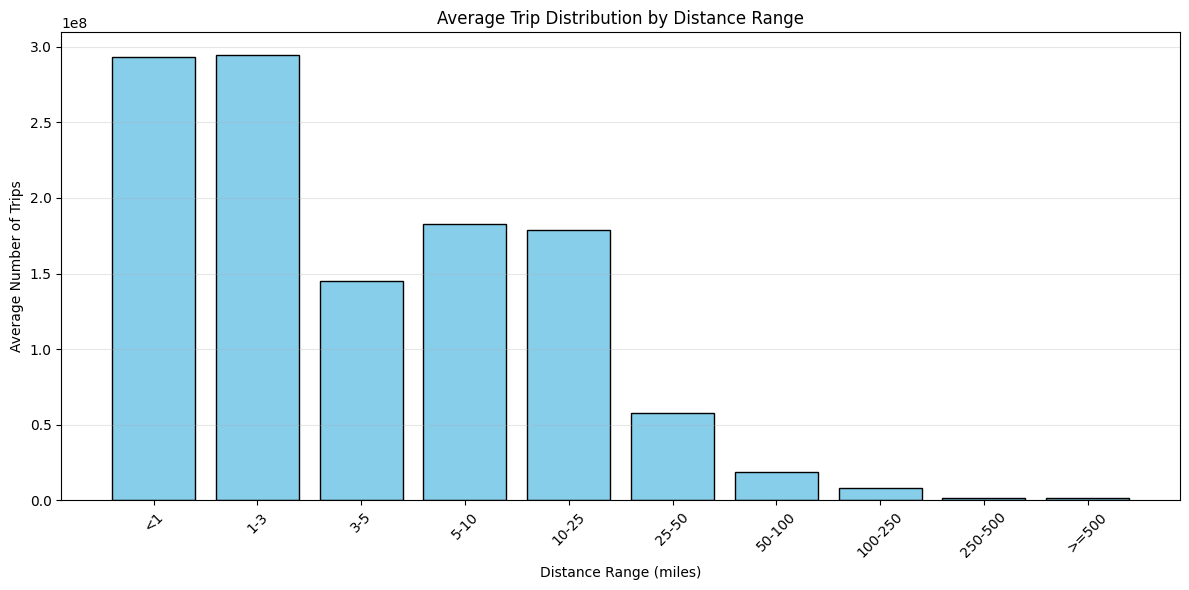

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))

trip_data = national_data[trip_columns].mean()
distances = ['<1', '1-3', '3-5', '5-10', '10-25', '25-50', '50-100', '100-250', '250-500', '>=500']

bars = ax.bar(distances, trip_data.values, color='skyblue', edgecolor='black')
ax.set_xlabel('Distance Range (miles)')
ax.set_ylabel('Average Number of Trips')
ax.set_title('Average Trip Distribution by Distance Range')
ax.grid(True, alpha=0.3, axis='y')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('trip_distance_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


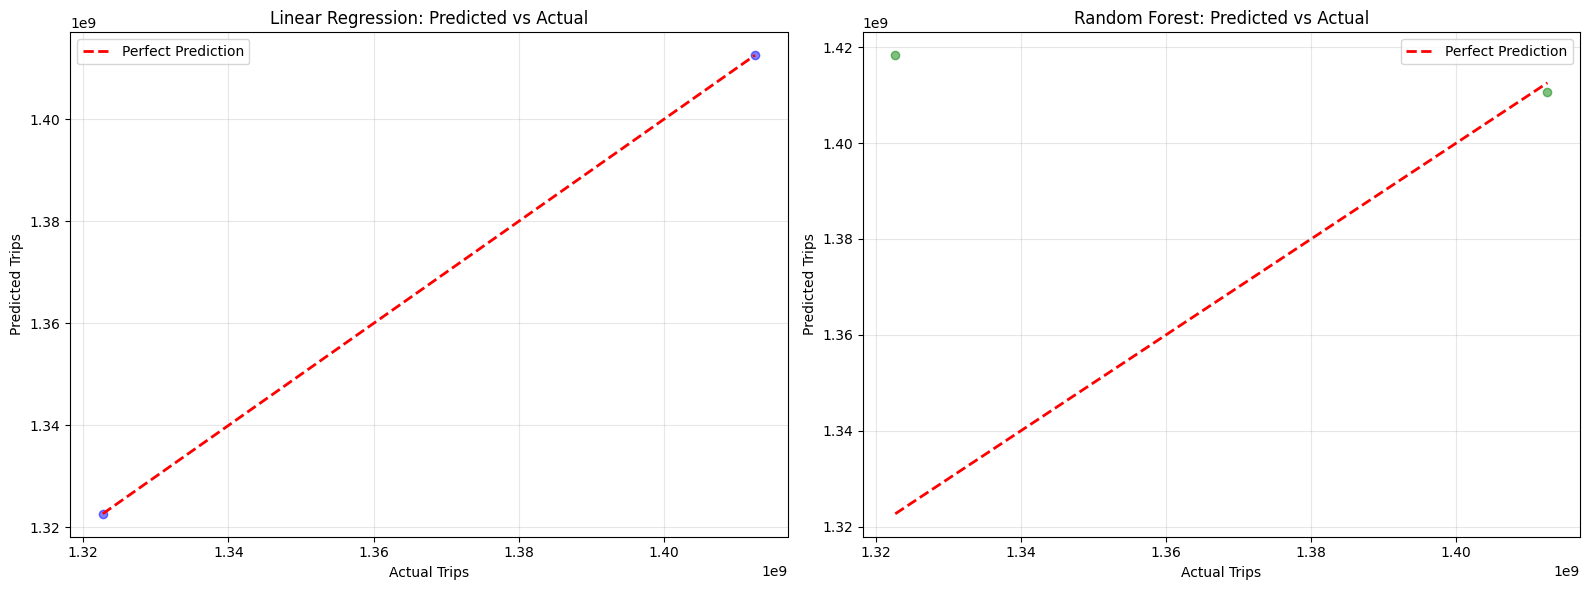

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.scatter(y_test, y_pred_lr, alpha=0.5, color='blue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Trips')
ax1.set_ylabel('Predicted Trips')
ax1.set_title('Linear Regression: Predicted vs Actual')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.scatter(y_test, y_pred_rf, alpha=0.5, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual Trips')
ax2.set_ylabel('Predicted Trips')
ax2.set_title('Random Forest: Predicted vs Actual')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
summary_stats = pd.DataFrame({
    'Analysis Component': [
        'Total Records Analyzed',
        'Date Range',
        'Average People Staying Home',
        'Average People Not Staying Home',
        'Average Travel Distance (miles)',
        'Sequential Processing Time (s)',
        'Parallel Processing Time - 10 cores (s)',
        'Parallel Processing Time - 20 cores (s)',
        'Best Speedup',
        'Best Model',
        'Best Model R² Score'
    ],
    'Value': [
        len(national_data),
        f"{national_data['Date'].min().date()} to {national_data['Date'].max().date()}",
        f"{national_data['Population Staying at Home'].mean():,.0f}",
        f"{national_data['Population Not Staying at Home'].mean():,.0f}",
        f"{national_data['Average_Distance'].mean():.2f}",
        f"{sequential_time:.4f}",
        f"{time_10:.4f}",
        f"{time_20:.4f}",
        f"{max(speedup_10, speedup_20):.2f}x",
        best_model,
        f"{max(r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_rf)):.4f}"
    ]
})

display(summary_stats)


,Analysis Component,Value
0,Total Records Analyzed,887
1,Date Range,2019-01-01 to 2021-06-05
2,Average People Staying Home,"72,908,388"
3,Average People Not Staying Home,"253,957,530"
4,Average Travel Distance (miles),10.35
5,Sequential Processing Time (s),0.0194
6,Parallel Processing Time - 10 cores (s),0.6624
7,Parallel Processing Time - 20 cores (s),1.7005
8,Best Speedup,0.03x
9,Best Model,Linear Regression


In [25]:
performance_comparison.to_csv('processing_performance.csv', index=False)
category_stats.to_csv('distance_categories.csv', index=False)
model_comparison.to_csv('model_comparison.csv', index=False)
summary_stats.to_csv('summary_statistics.csv', index=False)